In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - compare_potentials.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Compare MWPotential2014 to a similar potential that has a triaxial halo
'''

__author__ = "James Lane"

In [619]:
### Imports

## Basic
import numpy as np
import sys, os, pdb
import copy
# import glob
# import subprocess

## Plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
# from matplotlib.backends.backend_pdf import PdfPages
# from matplotlib import colors
from matplotlib import cm
# import aplpy

## Astropy
# from astropy.io import fits
# from astropy.coordinates import SkyCoord
# from astropy import table
from astropy import units as apu
# from astropy import wcs

## galpy
from galpy import orbit
from galpy import potential
from galpy.util import bovy_coords as gpcoords
from galpy.util import bovy_conversion as gpconv

from IPython.display import HTML

In [620]:
%matplotlib inline

# Compare potentials
We will compare MWPotential2014 with a potential that has the same disk and bulge but a TriaxialNFWPotential. First get all of the parameters of MWPotential2014

In [621]:
# Get MWPotential2014, unpack the component potentials, and save copies
mwpot = potential.MWPotential2014
mwbulge = copy.deepcopy(mwpot[0])
mwdisk = copy.deepcopy(mwpot[1])
mwhalo = copy.deepcopy(mwpot[2])

### Explore a range in c: the ratio of the vertical to primary scale lengths

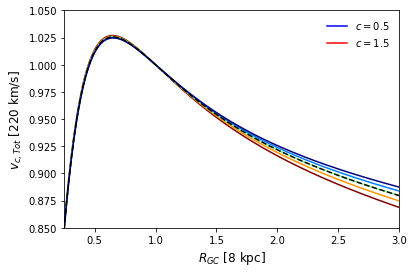

In [623]:
# Declare the range of c to explore
c_range = np.array([0.5,0.75,1.0,1.25,1.5])

# Start the figure
fig = plt.figure()
ax = fig.add_subplot(111)
cmap = cm.get_cmap('jet')

# Loop over the values of c
for i in range(len(c_range)):
    
    # Declare the triaxial NFW
    tripot_halo = potential.TriaxialNFWPotential(amp=mwhalo._amp,
                                                 a=mwhalo.a,
                                                 b=1.0,
                                                 c=c_range[i],
                                                 normalize=0.35)
    tripot = [tripot_halo,mwbulge,mwdisk]
    
    # Plot the rotation curve
    norm_val = (np.max(c_range)-c_range[i])/(np.max(c_range)-np.min(c_range))
    potential.plotRotcurve(tripot, Rrange=[0.1,10.], grid=1001, overplot=True, phi=0, color=cmap(norm_val))
###i

# Plot the MWPotential2014 rotation curve
potential.plotRotcurve(mwpot, Rrange=[0.1,10.], grid=1001, overplot=True, phi=0, color='Black', 
                       linestyle='dashed')

ax.plot([], [], c='Blue', label=r'$c=$'+str(np.min(c_range)))
ax.plot([], [], c='Red', label=r'$c=$'+str(np.max(c_range)))
leg = ax.legend(loc='upper right', frameon=False)

ax.set_xlim(0.25,3.0)
ax.set_ylim(0.85,1.05)
ax.set_ylabel(r'$v_{c,Tot}$ [220 km/s]', fontsize=12)
ax.set_xlabel(r'$R_{GC}$ [8 kpc]', fontsize=12)

fig.savefig('tripot_c.pdf')
plt.show()
plt.close('all')

### Explore a range in $\phi$ with b set to 1.25, 1.5, 2.0: The ratio of the primary to secondary axes

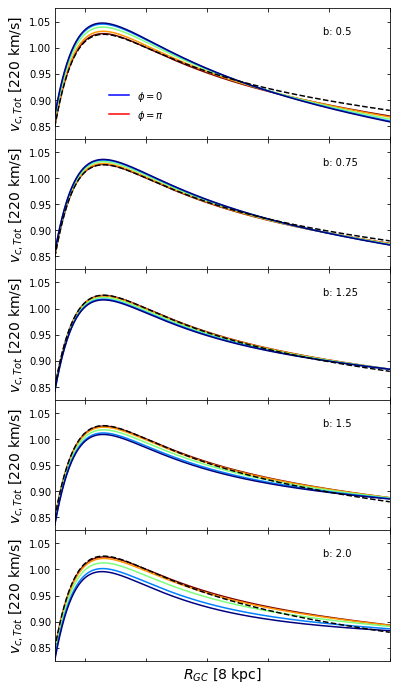

In [625]:
# Declare the range of c to explore
phi_range = np.linspace(0,np.pi/2,num=5)
b_range = np.array([0.5,0.75,1.25,1.5,2.0])

# Start the figure
fig = plt.figure(figsize=(6,12))
axs = fig.subplots(nrows=len(b_range), ncols=1)

for i in range(len(b_range)):
    
    plt.sca(axs[i])
    
    for j in range(len(phi_range)):
        
        # Declare the triaxial NFW
        tripot_halo = potential.TriaxialNFWPotential(amp=mwhalo._amp,
                                                     a=mwhalo.a,
                                                     b=b_range[i],
                                                     c=1.0,
                                                     normalize=0.35)
        tripot = [tripot_halo,mwbulge,mwdisk]
    
        # Plot the rotation curve
        norm_val = (np.max(phi_range)-phi_range[j])/(np.max(phi_range)-np.min(phi_range))
        potential.plotRotcurve(tripot, Rrange=[0.1,10.], grid=1001, overplot=True, phi=phi_range[j], 
                               color=cmap(norm_val))
    ###j
    
    potential.plotRotcurve(mwpot, Rrange=[0.1,10.], grid=1001, overplot=True, phi=0, color='Black', 
                           linestyle='dashed')
    
    axs[i].set_xlim(0.25,3.0)
    axs[i].set_ylim(0.825,1.075)
    axs[i].annotate('b: '+str(b_range[i]), (0.8,0.8), xycoords='axes fraction')
    axs[i].tick_params(direction='in', top='on', right='on', labelbottom='off')
    axs[i].set_ylabel(r'$v_{c,Tot}$ [220 km/s]', fontsize=14)
###i

axs[0].plot([], [], c='Blue', label=r'$\phi=0$')
axs[0].plot([], [], c='Red', label=r'$\phi=\pi$')
leg = axs[0].legend(loc=(0.15,0.1), frameon=False)
axs[-1].set_xlabel(r'$R_{GC}$ [8 kpc]', fontsize=14)

fig.subplots_adjust(hspace=0)
fig.savefig('tripot_bphi.pdf')
plt.show()
plt.close('all')

### Now try doing Dehnen growth

In [576]:
# Scalp potential parameters for physical implementation
mwhalo_a = mwhalo.a * mwhalo._ro * apu.kpc
mwhalo_amp = mwhalo.dens(mwhalo_scale,0) * 16 * mwhalo.a**3 * np.pi * \
             gpconv.mass_in_msol(mwhalo._vo, mwhalo._ro) * apu.M_sun

mwdisk_a = mwdisk._a * mwdisk._ro * apu.kpc
mwdisk_b = mwdisk._b * mwdisk._ro * apu.kpc
mwdisk_amp = mwdisk._amp * gpconv.mass_in_msol(mwdisk._vo, mwdisk._ro) * apu.M_sun

mwbulge_r1 = 1
mwbulge_amp = mwbulge.dens(mwbulge_r1,0) * np.exp((1/mwbulge.rc)**2) * \
              gpconv.dens_in_msolpc3(mwhalo._vo, mwhalo._ro) * apu.M_sun / apu.pc**3 
mwbulge_alpha = mwbulge.alpha
mwbulge_rc = mwbulge.rc * mwbulge._ro * apu.kpc

In [577]:
# Generate the scalped potentials
mwbulge_scal = potential.PowerSphericalPotentialwCutoff(amp=mwbulge_amp, alpha=mwbulge_alpha, rc=mwbulge_rc)
mwbulge_scal.turn_physical_off()
mwdisk_scal = potential.MiyamotoNagaiPotential(amp=mwdisk_amp, a=mwdisk_a, b=mwdisk_b)
mwdisk_scal.turn_physical_off()
mwhalo_scal = potential.NFWPotential(amp=mwhalo_amp, a=mwhalo_a)
mwhalo_scal.turn_physical_off()

mwpot_scal = [mwhalo_scal, mwdisk_scal, mwbulge_scal]

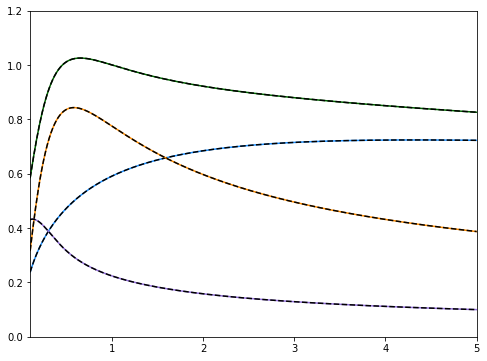

In [579]:
# Check the rotation curve.

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

mwhalo_scal.plotRotcurve(Rrange=[0.1,10],grid=1001,overplot=True, phi=0, color='DodgerBlue')
mwhalo.plotRotcurve(Rrange=[0.1,10],grid=1001,overplot=True, phi=0, color='Black', linestyle='dashed')
mwdisk_scal.plotRotcurve(Rrange=[0.1,10],grid=1001,overplot=True, phi=0, color='DarkOrange')
mwdisk.plotRotcurve(Rrange=[0.1,10],grid=1001,overplot=True, phi=0, color='Black', linestyle='dashed')
mwbulge_scal.plotRotcurve(Rrange=[0.1,10],grid=1001,overplot=True, phi=0, color='MediumPurple')
mwbulge.plotRotcurve(Rrange=[0.1,10],grid=1001,overplot=True, phi=0, color='Black', linestyle='dashed')
potential.plotRotcurve(mwpot_scal, Rrange=[0.1,10],grid=1001,overplot=True, phi=0, color='DarkGreen')
potential.plotRotcurve(mwpot, Rrange=[0.1,10],grid=1001,overplot=True, phi=0, color='Black', linestyle='dashed')

ax.set_xlim(0.1,5)
ax.set_ylim(0,1.2)
plt.show()

In [626]:
# Make the triaxial halo
trihalo_scal = potential.TriaxialNFWPotential(amp=mwhalo_amp,
                                             a=mwhalo_a,
                                             b=2.0,
                                             c=1.0)
trihalo_scal.turn_physical_off()

# Make the negative amplitude NFW
mwhalo_scal_rev = potential.NFWPotential(amp=mwhalo_amp*-1,
                                    a=mwhalo_a)
mwhalo_scal_rev.turn_physical_off()

# Wrap the potentials in the Dehnen Smooth wrapper
# One is the triaxial NFW, which grows. Another is the MWPotential2014 NWF, which grows negatively in time.
# Finally wrap with the MWPotential2014 halo, which is constant, and will cancel out the negatively growing 
# MWPotential2014 halo when it is fully grown, leaving the triaxial halo
trihalo_scal_dsw = potential.DehnenSmoothWrapperPotential(pot=trihalo_scal, tform=3.*apu.Gyr, tsteady=4.*apu.Gyr)
trihalo_scal_dsw.turn_physical_off()
mwhalo_scal_rev_dsw = potential.DehnenSmoothWrapperPotential(pot=mwhalo_scal_rev, tform=3.*apu.Gyr, tsteady=4.*apu.Gyr)
mwhalo_scal_rev_dsw.turn_physical_off()

# All together
tripot_grow = [mwhalo_scal_rev_dsw, 
               mwhalo_scal, 
               trihalo_scal_dsw, 
               mwdisk_scal, 
               mwbulge_scal]

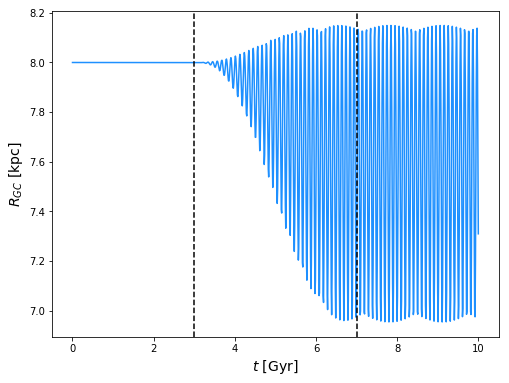

In [628]:
# Start the figure
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# potential.plotRotcurve(tripot, Rrange=[0.1,10.], grid=1001, overplot=True, phi=0, 
#                        color=cmap(norm_val))

o = orbit.Orbit(vxvv=[8.*apu.kpc, 
                      0.*apu.km/apu.s, 
                      220.*apu.km/apu.s, 
                      0.*apu.radian])

times = np.linspace(0,10,num=1000)*apu.Gyr
o.integrate(times, tripot_grow)

ax.plot( times, o.R(times), color='DodgerBlue')
ax.set_xlabel(r'$t$ [Gyr]', fontsize=14)
ax.set_ylabel(r'$R_{GC}$ [kpc]', fontsize=14)
#ax.set_ylim(7.5,8.5)
ax.axvline(3, color='Black', linestyle='dashed')
ax.axvline(7, color='Black', linestyle='dashed')

fig.savefig('tripot_growhalo.pdf')
plt.show()
plt.close('all')

Not working?? Normalization maybe?

In [602]:
# Make the triaxial potential and bundle it with the Milky Way
tripot_halo = potential.TriaxialNFWPotential(amp=mwhalo._amp,
                                             a=mwhalo.a,
                                             b=1.5,
                                             c=1.0,
                                             normalize=0.35)

mwhalo_rev = potential.NFWPotential(amp=mwhalo._amp*-1,
                                    a=mwhalo.a,
                                    normalize=0.35)
tripot = [mwbulge, mwdisk, tripot_halo]

# Wrap the potentials in the Dehnen Smooth wrapper
# One is the triaxial NFW, which grows. Another is the MWPotential2014 NWF, which grows negatively in time.
# Finally wrap with the MWPotential2014 halo, which is constant, and will cancel out the negatively growing 
# MWPotential2014 halo when it is fully grown, leaving the triaxial halo
tripot_halo_sdw = potential.DehnenSmoothWrapperPotential(pot=tripot_halo, tform=-8.*apu.Gyr, tsteady=4.*apu.Gyr)
mwhalo_rev_sdw = potential.DehnenSmoothWrapperPotential(pot=mwhalo_rev, tform=-8.*apu.Gyr, tsteady=4.*apu.Gyr)

# Bundle. This potential should smoothly interpolate between a spherical and triaxial halo.
tripot_grow = [tripot_halo_sdw, mwhalo, mwbulge, mwdisk, mwhalo_rev_sdw]

# Triaxial potential force function bug?

In [603]:
# Get MWPotential2014, unpack the component potentials, and save copies
mwpot = potential.MWPotential2014
mwbulge = copy.deepcopy(mwpot[0])
mwdisk = copy.deepcopy(mwpot[1])
mwhalo = copy.deepcopy(mwpot[2])

In [604]:
# Define the triaxial potential
pot_trihalo = potential.TriaxialNFWPotential(amp=mwhalo._amp,
                                             a=mwhalo.a,
                                             b=1.0,
                                             c=1.0,
                                             normalize=0.35)

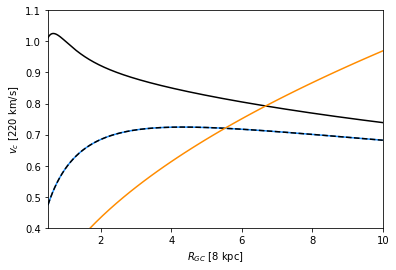

In [615]:
pot_trihalo.plotRotcurve(Rrange=[0.5,10],grid=1001,overplot=True, phi=0, color='DodgerBlue')
mwhalo.plotRotcurve(Rrange=[0.5,10],grid=1001,overplot=True, color='Black', linestyle='dashed')
potential.plotRotcurve(mwpot, Rrange=[0.5,10], grid=1001, overplot=True, color='Black')

ax = plt.gca()
ax.set_xlim(0.5,10)
ax.set_ylim(0.4,1.1)
ax.set_ylabel(r'$v_{c}$ [220 km/s]')
ax.set_xlabel(r'$R_{GC}$ [8 kpc]')

#vcs = potential.vcirc(pot_trihalo, np.linspace(0.5,10.0,num=50), phi=0)
pot_trihalo.turn_physical_off()
vcs = pot_trihalo.vcirc(np.linspace(0.5,10.0,num=50), phi=0)
ax.plot(np.linspace(0.5,10.0,num=50), vcs, color='DarkOrange')

plt.show()
plt.close('all')

Make movies of the potential evolving in time

In [616]:
np.sqrt( -1*pot_trihalo.Rforce(np.linspace(1,5,num=50), 0, phi=0) * np.linspace(1,5,num=50) ) 

array([0.39516972, 0.41098271, 0.42620942, 0.4409106 , 0.45513716,
       0.46893232, 0.48233308, 0.49537146, 0.50807536, 0.52046926,
       0.53257481, 0.54441125, 0.55599577, 0.56734379, 0.57846924,
       0.58938472, 0.60010168, 0.61063058, 0.62098099, 0.63116169,
       0.64118075, 0.65104565, 0.66076329, 0.67034006, 0.67978194,
       0.68909445, 0.69828279, 0.70735177, 0.71630595, 0.72514957,
       0.73388663, 0.74252088, 0.75105589, 0.75949498, 0.76784133,
       0.77609793, 0.7842676 , 0.79235305, 0.80035682, 0.80828134,
       0.81612891, 0.82390174, 0.83160193, 0.83923146, 0.84679226,
       0.85428614, 0.86171486, 0.86908008, 0.8763834 , 0.88362636])

In [629]:
print( np.sqrt( -1*pot_trihalo.Rforce(1, 0, phi=0) * 1 )  )
print( np.sqrt( -1*pot_trihalo.Rforce(5, 0, phi=0) * 5 )  )

0.5916079783099616
0.722885298575977


In [631]:
pot_trihalo.Rforce( np.linspace(1,5,num=50), np.linspace(0,0,num=50), np.linspace(0,0,num=50))

ValueError: operands could not be broadcast together with shapes (49,) (50,) 